c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

📊 RNN Model Metrics:
Specificity: 0.7264
Accuracy: 0.7810
Sensitivity: 0.8365
Precision: 0.7500
F1 Score: 0.7909
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


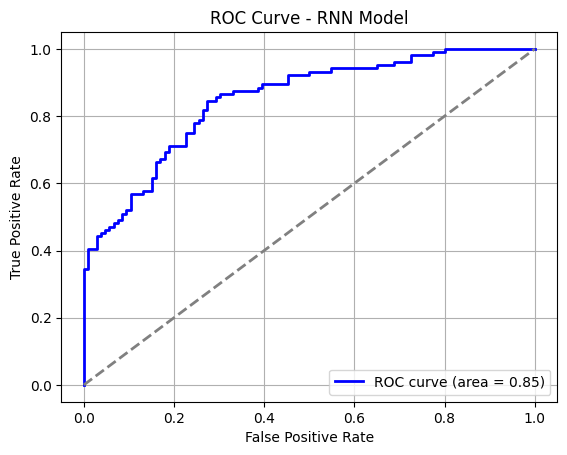

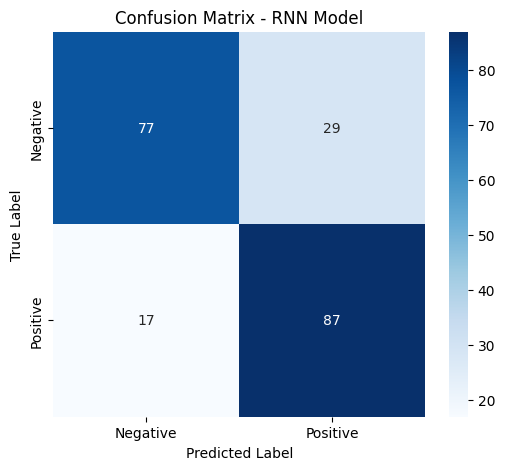

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing as pre
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, make_scorer
from sklearn.base import BaseEstimator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the dataset
data = pd.read_csv('final-dataset.csv')

# Prepare features and labels
X = data.drop(columns=['Signal', 'Label', 'Hurst Component'])
y = data['Label']

# Feature scaling
X = pre.scale(X)

# VarianceThreshold feature selection
def variance_threshold_selector(data, threshold=0.8):
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data)
    selector = VarianceThreshold(threshold)
    data_selected = selector.fit_transform(data)
    return pd.DataFrame(data_selected, columns=data.columns[selector.get_support(indices=True)])

X = variance_threshold_selector(X, threshold=0.8 * (1 - 0.8))

# Train-test-validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

# Reshape for RNN (samples, timesteps, features)
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
x_test = x_test.values.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_val = x_val.values.reshape((x_val.shape[0], 1, x_val.shape[1]))

# Custom Keras RNN Classifier compatible with GridSearchCV
class KerasRNNClassifier(BaseEstimator):
    def __init__(self, optimizer='adam', units=64, dropout_rate=0.5, init='glorot_uniform', batch_size=64, epochs=50):
        self.optimizer = optimizer
        self.units = units
        self.dropout_rate = dropout_rate
        self.init = init
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None

    def create_rnn_model(self, input_shape):
        model = Sequential()
        model.add(LSTM(self.units, input_shape=input_shape, return_sequences=True, kernel_initializer=self.init))
        model.add(Dropout(self.dropout_rate))
        model.add(LSTM(self.units // 2, kernel_initializer=self.init))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(1, activation='sigmoid'))  # Binary classification
        model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X, y):
        self.model = self.create_rnn_model((X.shape[1], X.shape[2]))
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int)

    def predict_proba(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

# Define hyperparameter grid
parameters_rnn = {
    'batch_size': [16, 32],
    'epochs': [50],
    'optimizer': ['adam'],
    'units': [64, 128],
    'dropout_rate': [0.2, 0.5],
    'init': ['glorot_uniform']
}

# Instantiate model
model = KerasRNNClassifier()

# GridSearchCV setup
grid_search_rnn = GridSearchCV(
    estimator=model,
    param_grid=parameters_rnn,
    scoring=make_scorer(accuracy_score),
    n_jobs=-1,
    cv=3
)

# Run grid search
grid_search_rnn.fit(X_train, y_train)

# Best model
best_model_rnn = grid_search_rnn.best_estimator_

# Predict and evaluate
y_pred_rnn = best_model_rnn.predict(x_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rnn).ravel()
specificity_rnn = tn / (tn + fp)
accuracy_rnn = (tp + tn) / (tp + tn + fp + fn)
sensitivity_rnn = tp / (tp + fn)
precision_rnn = tp / (tp + fp)
f1_Score = 2 * (precision_rnn * sensitivity_rnn) / (precision_rnn + sensitivity_rnn)

print("\n📊 RNN Model Metrics:")
print(f"Specificity: {specificity_rnn:.4f}")
print(f"Accuracy: {accuracy_rnn:.4f}")
print(f"Sensitivity: {sensitivity_rnn:.4f}")
print(f"Precision: {precision_rnn:.4f}")
print(f"F1 Score: {f1_Score:.4f}")

# ROC Curve
y_pred_proba_rnn = best_model_rnn.predict_proba(x_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rnn)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Confusion Matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rnn, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - RNN Model")
plt.show()
